# План

1. EDA<br>
1.1 `customers_df`<br>
1.2 `orders_df`<br>
1.3 `order_items_df`<br>
2. Ответы на вопросы<br>
2.1 Сколько у нас пользователей, которые совершили покупку только один раз?<br>
2.2 Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?<br>
2.3 В какой день недели каждый товар чаще всего покупается?<br>
2.4 Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?
3. Когортный анализ с расчетом Retention Rate
4. RFM-сегментация
5. Рекомендации для групп

# 1. EDA

Для начала импортируем библиотеки, считаем датасеты, подготовим их для дальнейшей работы и проведем предварительное исследование данных.

In [1]:
# Импортируем нужные библиотеки

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import requests
from urllib.parse import urlencode

In [2]:
pip install squarify

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/opt/tljh/user/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Импортируем библиотеку для построения treemap (понадобится для задания)
# Для того чтобы ее импортировать, устанавливаем пакет squarify

import squarify as sq

In [4]:
# Ссылки на датасеты

customers_link = 'https://disk.yandex.ru/d/QXrVDUoQvFhIcg'
orders_link = 'https://disk.yandex.ru/d/0zWmh1bYP6REbw'
order_items_link = 'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg'

In [5]:
# Функция для формирования ссылки на датасет для считывания

def get_download_url(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

In [6]:
# Считываем датасеты и записываем их в датафреймы

customers_df = pd.read_csv(get_download_url(customers_link))
orders_df = pd.read_csv(get_download_url(orders_link), parse_dates=['order_purchase_timestamp',
                                                                    'order_approved_at',
                                                                    'order_delivered_carrier_date',
                                                                    'order_delivered_customer_date',
                                                                    'order_estimated_delivery_date'])
order_items_df = pd.read_csv(get_download_url(order_items_link), parse_dates=['shipping_limit_date'])

Посмотрим, как выглядят наши датафреймы, сколько в них наблюдений и столбцов, типы данных и кол-во пропусков.

## 1.1 `customers_df`

Датафрейм с уникальными идентификаторами пользователей.

In [7]:
customers_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [8]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [9]:
# Проверяем кол-во пропущенных значений
customers_df.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [10]:
customers_df.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

Уникальное кол-во `customer_id` совпадает с кол-вом наблюдений в датафрейме, то есть каждая строка - это новый customer_id, дублей нет. А вот в столбце `customer_unique_id` есть повторяющиеся значения, то есть каждому `customer_unique_id` может соответствовать несколько `customer_id`, скорее всего, при заказе для `customer_unique_id` каждый раз присваивается новый `customer_id`, поэтому их несколько.

## 1.2 `orders_df`

Датафрейм с заказами.

In [11]:
orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [12]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


Кол-во наблюдений в `orders_df` совпадает с кол-вом наблюдений `customers_df`.

In [13]:
# Проверяем кол-во пропущенных значений
orders_df.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

`order_approved_at` — время подтверждения оплаты заказа<br>
`order_delivered_carrier_date` — время передачи заказа в логистическую службу<br>
`order_delivered_customer_date` — время доставки заказа

В данных столбцах могут быть пропущенные значения, скорее всего, из-за того, что пока на данный момент оплата могла не подтвердиться, заказ не передан в логистическую службу или не доставлен до покупателя.

In [14]:
orders_df.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64

In [15]:
orders_df.customer_id.nunique() == customers_df.customer_id.nunique()

True

Кол-во уникальных `customer_id` в `orders_df` совпадает с кол-вом уникальных `customer_id` в `customers_df`.

## 1.3 `order_items_df`

Датафрейм с товарами, входящими в заказы.

In [16]:
order_items_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [17]:
order_items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


In [18]:
# Проверяем кол-во пропущенных значений
order_items_df.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [19]:
order_items_df.nunique()

order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64

In [20]:
order_items_df.order_id.nunique() == orders_df.order_id.nunique()

False

In [21]:
order_items_df.order_id.nunique()

98666

In [22]:
orders_df.order_id.nunique()

99441

Видим, что кол-во уникальных `order_id` в `order_items_df` не совпадает с кол-вом уникальных `order_id` в `orders_df`. В датафрейме с детализацией по товарам меньше заказов.

In [23]:
# Проверим, есть ли отрицательные значения или 0 у price
order_items_df.query('price <= 0')

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value


In [24]:
# Проверим, есть ли отрицательные значения или 0 у freight_value
order_items_df.query('freight_value <= 0')

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
114,00404fa7a687c8c44ca69d42695aae73,1,53b36df67ebb7c41585e8d54d6772e08,7d13fca15225358621be4086e1eb0964,2018-05-15 04:31:26,99.9,0.0
258,00a870c6c06346e85335524935c600c0,1,aca2eb7d00ea1a7b8ebd4e68314663af,955fee9216a65b617aa5c0531780ce60,2018-05-14 00:14:29,69.9,0.0
483,011c899816ea29773525bd3322dbb6aa,1,53b36df67ebb7c41585e8d54d6772e08,7d13fca15225358621be4086e1eb0964,2018-05-07 05:30:45,99.9,0.0
508,012b3f6ab7776a8ab3443a4ad7bef2e6,1,422879e10f46682990de24d770e7f83d,1f50f920176fa81dab994f9023523100,2018-05-09 21:30:50,53.9,0.0
509,012b3f6ab7776a8ab3443a4ad7bef2e6,2,422879e10f46682990de24d770e7f83d,1f50f920176fa81dab994f9023523100,2018-05-09 21:30:50,53.9,0.0
...,...,...,...,...,...,...,...
111094,fc698f330ec7fb74859071cc6cb29772,1,422879e10f46682990de24d770e7f83d,1f50f920176fa81dab994f9023523100,2018-04-25 02:31:57,53.9,0.0
111497,fd4907109f6bac23f07064af84bec02d,1,7a10781637204d8d10485c71a6108a2e,4869f7a5dfa277a7dca6462dcf3b52b2,2018-04-30 11:31:32,219.0,0.0
111649,fd95e4b85ebbb81853d4a6be3d61432b,1,53b36df67ebb7c41585e8d54d6772e08,4869f7a5dfa277a7dca6462dcf3b52b2,2018-05-04 11:10:31,106.9,0.0
112182,fee19a0dc7358b6962a611cecf6a37b4,1,f1c7f353075ce59d8a6f3cf58f419c9c,37be5a7c751166fbc5f8ccba4119e043,2017-09-07 22:06:31,195.0,0.0


In [25]:
order_items_df.query('freight_value <= 0').product_id.nunique()

10

Выясняем, что у нас нет товаров стоимостью меньше 0, но есть товары с весом 0 (383 наблюдения), причем таких товаров всего лишь 10 штук, скорее всего, это какие-то супер легкие товары, вес которых < 0.0.

# Ответы на вопросы

## 2.1 Сколько у нас пользователей, которые совершили покупку только один раз?

Прежде всего сформулируем, что должно считаться покупкой.

Сначала следует разобраться со статусами заказов. К покупке, по моему мнению, могут относиться все статусы, кроме created, unavailable и canceled.

Статус created не будет покупкой, так как факта оплаты, поступления денег на счет компании, еще нет. Статус unavailable будет интерпретироваться, как невозможность выполнить заказ, возможно, у продавца отсутствуют товары на складе. Статус canceled можно понимать, как отмена заказа со стороны покупателя.

Также не буду включать те наблюдения, которые не имеют времени подтверждения оплаты заказа, так как покупка - это оплаченный заказ.

Теперь нужно определить, кто в наших данных уникальный пользователь.

В рамках EDA мы выяснили, что каждому `customer_unique_id` может соответствовать несколько `customer_id` (данные о кастомере, соответствующие определенному заказу, то есть каждому заказу присваивается новый `customer_id`), поэтому определить уникальных кастомеров можно только с помощью колонки `customer_unique_id` в датафрейме `customers_df`.

In [26]:
# Смерджим датафрейм с заказами и кастомерами (так как нам нужен customer_unique_id)
# Для удобства передвинем добавленный столбец в начало датафрейма

orders_with_customers = orders_df.merge(customers_df[['customer_id', 'customer_unique_id']],
                                        how='left',
                                        on='customer_id')
orders_with_customers = orders_with_customers[list(orders_with_customers.columns)[-1:] +
                                              list(orders_with_customers.columns)[:-1]]
orders_with_customers.head()

,customer_unique_id,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [27]:
# Создадим датафрейм с покупками, он может нам понадобиться в дальнейшем

purchases_df = orders_with_customers.query("order_status not in ['created', 'unavailable', 'canceled'] & order_approved_at.notna()")
purchases_df.head()

,customer_unique_id,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [28]:
# Считаем кол-во кастомеров с одной покупкой

one_purchase = purchases_df.groupby('customer_unique_id', as_index=False) \
    .agg({'order_id': 'count'}) \
    .query('order_id == 1')
one_purchase

,customer_unique_id,order_id
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
94968,fffcf5a5ff07b0908bd4e2dbc735a684,1
94969,fffea47cd6d3cc0a88bd621562a9d061,1
94970,ffff371b4d645b6ecea244b27531430a,1
94971,ffff5962728ec6157033ef9805bacc48,1


Видим, что у нас 92087 пользователей, которые совершили покупку только один раз.

## 2.2 Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

Для начала нам нужно определить, что мы будем понимать под недоставленными заказами. К недоставленным заказам, по моему мнению, относятся все заказы со статусами canceled и unavailable.

Далее найдем среднемесячные величины для заказов, удовлетворяющим таким статусам.

In [29]:
# Приведем дату ожидаемой доставки к месяцу
orders_df['order_estimated_delivery_month'] = orders_df.order_estimated_delivery_date.dt.to_period('M') \
                                                                                     .dt.to_timestamp()

In [30]:
# Создадим датафрейм с недоставленными заказами

undelivered_orders = orders_df.query('order_status == "canceled" or order_status == "unavailable"') \
    .groupby(['order_estimated_delivery_month', 'order_status'], as_index=False) \
    .agg({'order_id': 'count'}) \
    .pivot(columns='order_status', index='order_estimated_delivery_month', values='order_id')
undelivered_orders.head()

order_status,canceled,unavailable
order_estimated_delivery_month,,
2016-09-01,1.0,NaN
2016-10-01,3.0,NaN
2016-11-01,14.0,5.0
2016-12-01,8.0,2.0
2017-02-01,2.0,2.0


Так как в задаче не указано прямо, что нам для расчета среднего точно необходимо взять среднее арифметическое, то в качестве среднего я возьму медиану. Так мы узнаем значение кол-ва отмененных и недоступных заказов, меньше которого (для каждого типа недоставленных - canceled и unavailable) распределяются 50% наших наблюдений и больше которого находится 50% наших наблюдений. Медиана не так чувствительна к выбросам, как среднее арифметическое.<br>
В приниципе мы могли бы взять среднее арифметическое, так как имеем статусы, которые встречаются регулярно, но все же возьмем медиану.

In [31]:
# Посчитаем медианное кол-во отмененных заказов и округлим до целого

undelivered_orders_canceled_me = undelivered_orders.canceled.median().round()
undelivered_orders_canceled_me

22.0

In [32]:
# Посчитаем медианное кол-во недоступных заказов и округлим до целого

undelivered_orders_unavailable_me = undelivered_orders.unavailable.median().round()
undelivered_orders_unavailable_me

29.0

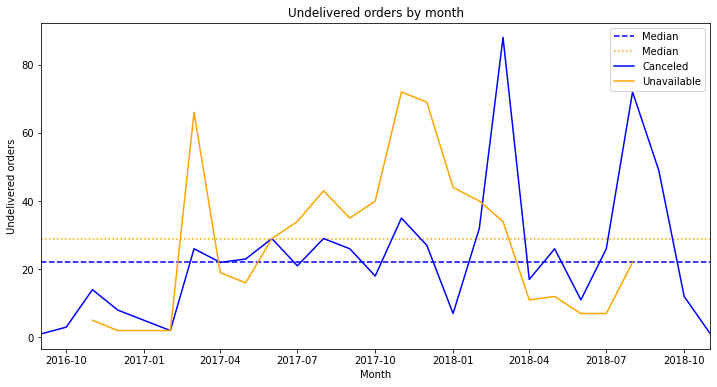

In [33]:
# Построим линейный график кол-ва отмененных и недоступных заказов по месяцам и покажем их медианы

plt.figure(figsize=(12, 6))
plt.title('Undelivered orders by month')
plt.xlabel('Month')
plt.ylabel('Undelivered orders')
plt.axhline(y=undelivered_orders_canceled_me, color='blue', linestyle='--', label='Median')
plt.axhline(y=undelivered_orders_unavailable_me, color='orange', linestyle=':', label='Median')
plt.xlim(min(undelivered_orders.reset_index().order_estimated_delivery_month.to_list()),
         max(undelivered_orders.reset_index().order_estimated_delivery_month.to_list()))

sns.lineplot(data=undelivered_orders,
             x='order_estimated_delivery_month', y='canceled', label='Canceled', color='blue')
sns.lineplot(data=undelivered_orders,
             x='order_estimated_delivery_month', y='unavailable', label='Unavailable', color='orange')

22 заказа в месяц в среднем (на основе медианы) не доставляются по причине отмены заказа, то есть 50% отмененных заказов меньше 22, оставшиеся 50% отмененных заказов больше 22.<br>
29 заказов в месяц в среднем (на основе медианы) не доставляются по причине недоступности заказа, то есть 50% недоступных заказов меньше 29, оставшиеся 50% недоступных заказов больше 29.

## 2.3 В какой день недели каждый товар чаще всего покупается?

Чтобы анализировать товары и их покупки нам понадобятся датафреймы `order_items_df` и `purchases_df` (полученный ранее).

In [34]:
order_items_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [35]:
purchases_df.head()

,customer_unique_id,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [36]:
# Объединим эти датафреймы

order_items_purchases = purchases_df[['customer_unique_id', 'order_id', 'order_purchase_timestamp']] \
    .merge(order_items_df, how='left', on='order_id')
order_items_purchases.head()

,customer_unique_id,order_id,order_purchase_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [37]:
# Добавляем день недели в датафрейм
# Перемещаем созданную колонку поближе к order_purchase_timestamp

order_items_purchases['order_purchase_weekday'] = order_items_purchases.order_purchase_timestamp.dt.strftime('%A')
order_items_purchases = order_items_purchases[list(order_items_purchases.columns)[:2] +
                                              list(order_items_purchases.columns)[-1:] +
                                              list(order_items_purchases.columns)[2:-1]]
order_items_purchases.head()

,customer_unique_id,order_id,order_purchase_weekday,order_purchase_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,Monday,2017-10-02 10:56:33,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,Tuesday,2018-07-24 20:41:37,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,Wednesday,2018-08-08 08:38:49,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,Saturday,2017-11-18 19:28:06,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,Tuesday,2018-02-13 21:18:39,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [38]:
# Группируем по товару и дню недели и считаем кол-во покупок

order_items_purchases_count = order_items_purchases.groupby(['product_id', 'order_purchase_weekday'], as_index=False) \
    .agg({'order_id': 'count'}) \
    .rename(columns={'order_id': 'purchases_count'})
order_items_purchases_count.head()

,product_id,order_purchase_weekday,purchases_count
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1


In [39]:
# Считаем максимальное кол-во покупок каждого товара среди всех дней недели

order_items_purchases_max = order_items_purchases_count.groupby('product_id', as_index=False) \
    .agg({'purchases_count': 'max'}) \
    .rename(columns={'purchases_count': 'purchases_max'})
order_items_purchases_max.head()

,product_id,purchases_max
0,00066f42aeeb9f3007548bb9d3f33c38,1
1,00088930e925c41fd95ebfe695fd2655,1
2,0009406fd7479715e4bef61dd91f2462,1
3,000b8f95fcb9e0096488278317764d19,1
4,000d9be29b5207b54e86aa1b1ac54872,1


In [40]:
# Объединяем датафреймы

order_items_purchases_by_weekday = order_items_purchases_count.merge(order_items_purchases_max,
                                                                     how='left',
                                                                     on='product_id')
order_items_purchases_by_weekday.head()

,product_id,order_purchase_weekday,purchases_count,purchases_max
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1,1
3,000b8f95fcb9e0096488278317764d19,Friday,1,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1,1


In [41]:
# Фильтруем наблюдения так, чтобы purchases_count совпал с purchases_max
# Так мы для каждого товара найдем день недели, в который он покупался больше всего среди всех дней недели

order_items_max_purchases_by_weekday = order_items_purchases_by_weekday.query('purchases_count == purchases_max') \
    .drop(columns='purchases_count') \
    .sort_values('purchases_max', ascending=False)
order_items_max_purchases_by_weekday.head()

,product_id,order_purchase_weekday,purchases_max
15812,422879e10f46682990de24d770e7f83d,Wednesday,93
36305,99a4788cb24856965c36a24e339b6058,Monday,92
40819,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
20009,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
13459,389d119b48cf3043d311335e499d9c6b,Thursday,67


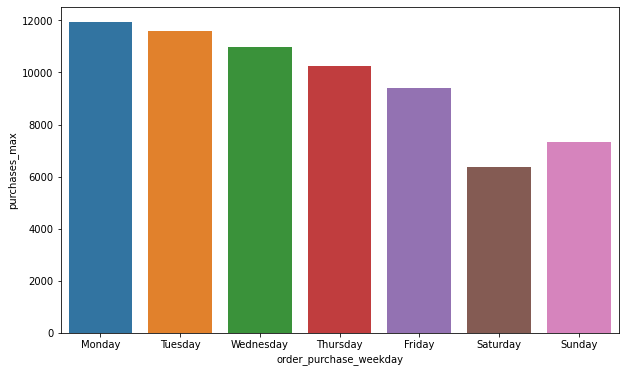

In [42]:
# Построим бар чарт

plt.figure(figsize=(10, 6))
sns.barplot(data=order_items_max_purchases_by_weekday.groupby('order_purchase_weekday', as_index=False) \
                                                     .purchases_max.sum(),
            x='order_purchase_weekday', y='purchases_max',
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

Как видим, на графике больше всего товаров покупается в понедельник, на выходных наши кастомеры покупают меньше, чем в будни.

В датафрейме `order_items_max_purchases_by_weekday` по каждому `product_id` можно определить, в какой день недели каждый товар чаще всего покупается и сколько таких покупок. Стоит понимать, что если для определенного товара максимальное число покупок по дням неделям совпадает, то в финальный датафрейм попадут все такие наблюдения (например, если один и тот же товар максимально купили 31 раз, причем как по понедельникам 31 раз, так и по четвергам 31 раз, то в датафрейме будут обе строки для этого товара - 31 для понедельника и 31 для четверга).

## 2.4 Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?

Здесь нам понадобятся данные с кастомерами и их покупками. У нас уже есть такой датафйрейм - `purchases_df`, который мы получили путем смёрдживания `orders_df` с `customers_df`, фильтрации по нужным статусам и наличием времени подтверждения оплаты заказа, чтобы вычленить только покупки.

In [43]:
purchases_df.head()

,customer_unique_id,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [44]:
# Определим минимальное и максимальное значение времени совершения покупки
purchases_df.order_purchase_timestamp.min(), purchases_df.order_purchase_timestamp.max()

(Timestamp('2016-09-04 21:15:19'), Timestamp('2018-09-03 09:06:57'))

Видим, что данные за сентябрь 2016 и сентябрь 2018 неполные, поэтому я уберу эти наблюдения для дальнейшего расчета, чтобы оставить только полные месяцы.

In [45]:
purchases_full_month = purchases_df.query('order_purchase_timestamp >= "2016-10-01" & order_purchase_timestamp < "2018-09-01"')

In [46]:
# Проверим, как отсеклись данные
purchases_full_month.order_purchase_timestamp.min(), purchases_full_month.order_purchase_timestamp.max()

(Timestamp('2016-10-03 09:44:50'), Timestamp('2018-08-29 15:00:37'))

In [47]:
# Создадим новую колонку - выделим месяц и год покупки
# pd.options.mode.chained_assignment = None нужно для того, чтобы убрать SettingWithCopyWarning

pd.options.mode.chained_assignment = None
purchases_full_month['order_purchase_month'] = purchases_full_month['order_purchase_timestamp'].dt.to_period('M')
purchases_full_month.head()

,customer_unique_id,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_month
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-07
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018-08
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017-11
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018-02


In [48]:
# Посчитаем кол-во заказов в месяц для каждого пользователя 

purchases_full_month_count = purchases_full_month.groupby(['customer_unique_id', 'order_purchase_month'],
                                                          as_index=False) \
    .size() \
    .rename(columns={'size': 'purchases_count'})
purchases_full_month_count.head()

,customer_unique_id,order_purchase_month,purchases_count
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1
2,0000f46a3911fa3c0805444483337064,2017-03,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1


In [49]:
# Запишем в новый столбец кол-во дней в месяце, в котором пользователь совершил покупку

purchases_full_month_count['days_in_month'] = purchases_df.order_purchase_timestamp.dt.days_in_month
purchases_full_month_count.head()

,customer_unique_id,order_purchase_month,purchases_count,days_in_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1,31.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1,31.0
2,0000f46a3911fa3c0805444483337064,2017-03,1,31.0
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1,30.0
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1,28.0


In [50]:
# Посчитаем кол-во недель для каждого месяца по наблюдениям 

purchases_full_month_count['number_of_weeks'] = purchases_full_month_count['days_in_month'] / 7
purchases_full_month_count.head()

,customer_unique_id,order_purchase_month,purchases_count,days_in_month,number_of_weeks
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1,31.0,4.428571
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1,31.0,4.428571
2,0000f46a3911fa3c0805444483337064,2017-03,1,31.0,4.428571
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1,30.0,4.285714
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1,28.0,4.000000


In [51]:
# Добавим еще один столбец, для каждого пользователя посчитаем среднее число покупок в неделю по месяцам

purchases_full_month_count['purchases_avg'] = purchases_full_month_count.purchases_count / purchases_full_month_count.number_of_weeks
purchases_full_month_count.head()

,customer_unique_id,order_purchase_month,purchases_count,days_in_month,number_of_weeks,purchases_avg
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1,31.0,4.428571,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1,31.0,4.428571,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03,1,31.0,4.428571,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1,30.0,4.285714,0.233333
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1,28.0,4.000000,0.250000


In [52]:
# Создадим финальный датафрейм, где отберем нужные нам колонки и отсортируем значения по убыванию

customer_purchases_by_week = purchases_full_month_count[['customer_unique_id', 'order_purchase_month', 'purchases_avg']] \
    .sort_values(by='purchases_avg', ascending=False)
customer_purchases_by_week.head()

,customer_unique_id,order_purchase_month,purchases_avg
7231,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,1.354839
50007,83e7958a94bd7f74a9414d8782f87628,2017-01,0.933333
61438,a239b8e2fbce33780f1f1912e2ee5275,2017-02,0.933333
66926,b08fab27d47a1eb6deda07bfd965ad43,2017-09,0.933333
23649,3e43e6105506432c953e165fb2acf44c,2018-02,0.903226


Проведем доп. исследование полученных данных.

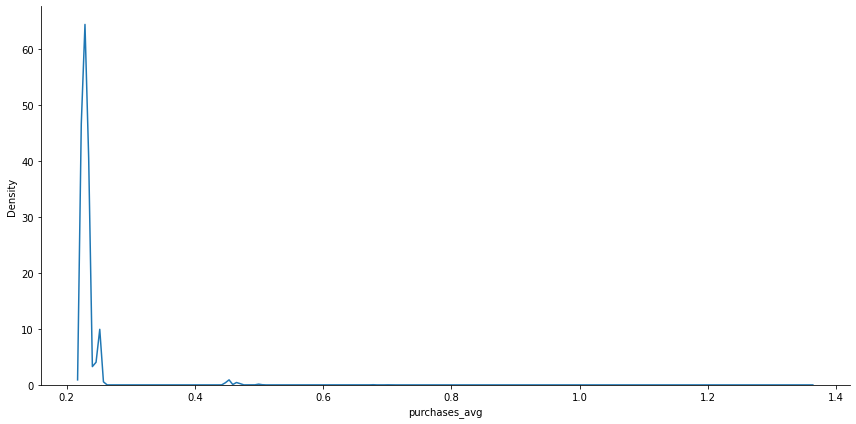

In [53]:
# Построим диаграмму распределения среднего числа покупок в неделю по месяцам для каждого пользователя
sns.displot(data=customer_purchases_by_week, x='purchases_avg', kind='kde', height=6, aspect=2)

In [54]:
customer_purchases_by_week.purchases_avg.describe().round(2)

count    95632.00
mean         0.23
std          0.03
min          0.23
25%          0.23
50%          0.23
75%          0.23
max          1.35
Name: purchases_avg, dtype: float64

In [55]:
customer_purchases_by_week.purchases_avg.quantile(0.99).round(2)

0.45

Видно, что в среднем у нас пользователи совершают 0.23 покупки в неделю, то есть можно сказать, что это примерно одна покупка в месяц.
У распределения длинный правый хвост, что говорит о выбросах и аномалиях. Таких значений крайне мало и только 1% наблюдений находится в диапазоне от 0.45 до 1.35 покупок в неделю.

# 3. Когортный анализ с расчетом Retention Rate

Определим для себя, что Retention Rate мы будем считать по столбцу `order_purchase_timestamp` - время создания заказа.<br>
Также стоит отметить, что для анализа будем использовать датафрейм с покупками - `purchases_df`, так как Retention Rate понимается, как отношение количества клиентов, которые совершили повторную покупку, к общему числу покупателей, поэтому нам нужны именно покупки.

In [56]:
purchases_df.head()

,customer_unique_id,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [57]:
# Посмотрим, каким периодом данных мы располагаем
purchases_df.order_purchase_timestamp.min(), purchases_df.order_purchase_timestamp.max()

(Timestamp('2016-09-04 21:15:19'), Timestamp('2018-09-03 09:06:57'))

Так как у нас неполные данные за 2016 и 2018 годы, то для когортного анализа возьмем полный 2017 год.

In [58]:
# Создаем новый датафрейм, связку customer_unique_id (пользователь) - order_purchase_timestamp (время покупки)

cohort = purchases_df[['customer_unique_id', 'order_purchase_timestamp']]
cohort.head()

,customer_unique_id,order_purchase_timestamp
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39


In [59]:
# Создадим новую колонку - выделим месяц и год покупки
# Возьмем только 2017 год

cohort['order_purchase_month'] = cohort['order_purchase_timestamp'].dt.to_period('M')
cohort = cohort.query('order_purchase_month >= "2017-01" and order_purchase_month <= "2017-12"')
cohort.head()

,customer_unique_id,order_purchase_timestamp,order_purchase_month
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11
5,80bb27c7c16e8f973207a5086ab329e2,2017-07-09 21:57:05,2017-07
6,36edbb3fb164b1f16485364b6fb04c73,2017-04-11 12:22:08,2017-04
7,932afa1e708222e5821dac9cd5db4cae,2017-05-16 13:10:30,2017-05


In [60]:
# Добавим столбец с месяцем первой покупки для каждого пользователя

cohort['first_purchase'] = cohort.groupby('customer_unique_id') \
    ['order_purchase_timestamp'].transform('min').dt.to_period('M')
cohort.head()

,customer_unique_id,order_purchase_timestamp,order_purchase_month,first_purchase
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10,2017-09
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11,2017-11
5,80bb27c7c16e8f973207a5086ab329e2,2017-07-09 21:57:05,2017-07,2017-07
6,36edbb3fb164b1f16485364b6fb04c73,2017-04-11 12:22:08,2017-04,2017-04
7,932afa1e708222e5821dac9cd5db4cae,2017-05-16 13:10:30,2017-05,2017-05


In [61]:
# Возьмем только нужные нам столбцы

cohort = cohort[['customer_unique_id', 'order_purchase_month', 'first_purchase']]
cohort.head()

,customer_unique_id,order_purchase_month,first_purchase
0,7c396fd4830fd04220f754e42b4e5bff,2017-10,2017-09
3,7c142cf63193a1473d2e66489a9ae977,2017-11,2017-11
5,80bb27c7c16e8f973207a5086ab329e2,2017-07,2017-07
6,36edbb3fb164b1f16485364b6fb04c73,2017-04,2017-04
7,932afa1e708222e5821dac9cd5db4cae,2017-05,2017-05


In [62]:
# Создаём размерность для наших когорт на основе разницы между текущей покупкой и первой

cohort['cohort_index'] = (cohort['order_purchase_month'] - cohort['first_purchase']).apply(lambda x: x.n)
cohort.head()

,customer_unique_id,order_purchase_month,first_purchase,cohort_index
0,7c396fd4830fd04220f754e42b4e5bff,2017-10,2017-09,1
3,7c142cf63193a1473d2e66489a9ae977,2017-11,2017-11,0
5,80bb27c7c16e8f973207a5086ab329e2,2017-07,2017-07,0
6,36edbb3fb164b1f16485364b6fb04c73,2017-04,2017-04,0
7,932afa1e708222e5821dac9cd5db4cae,2017-05,2017-05,0


In [63]:
# Считаем количество уникальных пользователей в каждой когорте для каждого периода

cohort = cohort.groupby(['first_purchase', 'cohort_index'], as_index=False)['customer_unique_id'].nunique()
cohort.head()

,first_purchase,cohort_index,customer_unique_id
0,2017-01,0,751
1,2017-01,1,3
2,2017-01,2,2
3,2017-01,3,1
4,2017-01,4,3


In [64]:
# Формируем сводную таблицу с количеством уникальных пользователей по когортам в каждый месяц 2017 года

cohort = cohort.pivot(index='first_purchase', columns='cohort_index', values='customer_unique_id')
cohort

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11
first_purchase,,,,,,,,,,,,
2017-01,751.0,3.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,3.0,1.0
2017-02,1678.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,1.0,3.0,2.0,NaN
2017-03,2571.0,13.0,9.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,NaN,NaN
2017-04,2326.0,14.0,5.0,4.0,7.0,6.0,8.0,7.0,7.0,NaN,NaN,NaN
2017-05,3541.0,17.0,17.0,14.0,11.0,12.0,15.0,5.0,NaN,NaN,NaN,NaN
2017-06,3102.0,14.0,11.0,12.0,8.0,12.0,11.0,NaN,NaN,NaN,NaN,NaN
2017-07,3823.0,20.0,13.0,9.0,11.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,4130.0,28.0,14.0,11.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4076.0,28.0,22.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
# Далее создаем таблицу когорт с Retention Rate

сohort_retention = cohort.divide(cohort.iloc[:, 0], axis=0).round(5)
сohort_retention

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11
first_purchase,,,,,,,,,,,,
2017-01,1.0,0.00399,0.00266,0.00133,0.00399,0.00133,0.00399,0.00133,0.00133,NaN,0.00399,0.00133
2017-02,1.0,0.00238,0.00298,0.00119,0.00417,0.00119,0.00238,0.00179,0.00060,0.00179,0.00119,NaN
2017-03,1.0,0.00506,0.00350,0.00389,0.00350,0.00156,0.00156,0.00311,0.00350,0.00078,NaN,NaN
2017-04,1.0,0.00602,0.00215,0.00172,0.00301,0.00258,0.00344,0.00301,0.00301,NaN,NaN,NaN
2017-05,1.0,0.00480,0.00480,0.00395,0.00311,0.00339,0.00424,0.00141,NaN,NaN,NaN,NaN
2017-06,1.0,0.00451,0.00355,0.00387,0.00258,0.00387,0.00355,NaN,NaN,NaN,NaN,NaN
2017-07,1.0,0.00523,0.00340,0.00235,0.00288,0.00209,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,1.0,0.00678,0.00339,0.00266,0.00363,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,0.00687,0.00540,0.00294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(159.0, 0.5, 'First purchase')

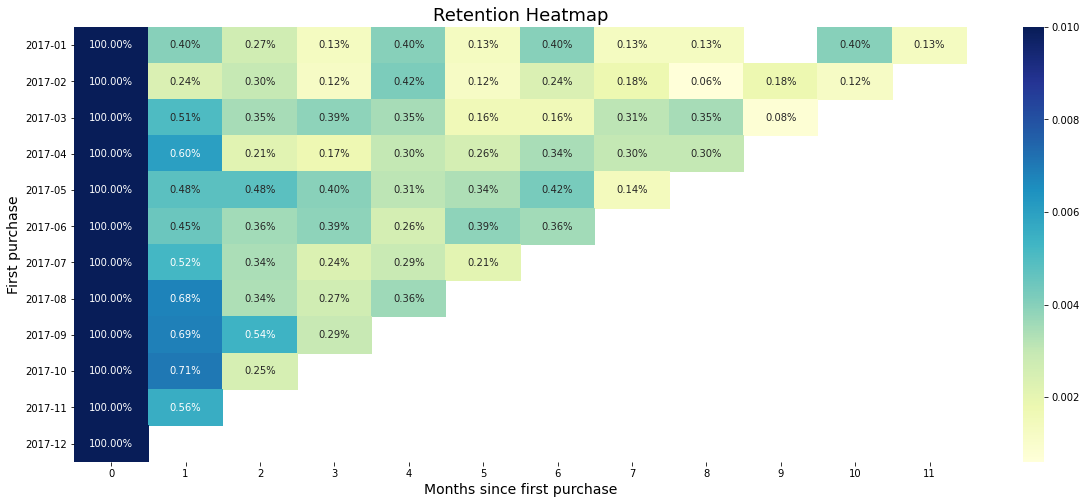

In [66]:
# Строим heatmap

plt.figure(figsize=(20, 8))
sns.heatmap(сohort_retention, vmax=0.01, annot=True, fmt='.2%', cmap='YlGnBu')
plt.title('Retention Heatmap', size=18)
plt.xlabel('Months since first purchase', size=14)
plt.ylabel('First purchase', size=14)

Найдем когорту с самым высоким Retention Rate на 3-й месяц. Если мы считаем, что нулевой день - это месяц первой покупки, то для нас 3 месяц - это месяц с индексом 3.

In [67]:
сohort_retention[3].idxmax()

Period('2017-05', 'M')

In [68]:
round(сohort_retention[3].max() * 100, 2)

0.4

Если мы считаем, что нулевой день - это месяц первой покупки, то когорта с самым высоким Retention Rate на 3-й месяц: 2017-05 со значением 0.4%.

Это значит, что среди всех 12 месяцев года, в которые каждый пользователь совершил свою первую покупку, максимальный процент тех, кто вернулся - 0.4% от тех пользователей, которые совершили свою первую покупку в мае 2017 и вернулись спустя 3 месяца после совершения своей первой покупки.

0.4% - это максимум среди всех возможных месяцев, в которые пользователь мог совершить первую покупку, чтобы вернуться спустя 3 месяца.

# 4. RFM-сегментация

Для того чтобы выполнить RFM-сегментацию нам нужны покупки, уникальные id пользователей и товары со стоимостью, которые пользователи купили. У нас уже есть такой датафрейм - `order_items_purchases`.

In [69]:
order_items_purchases.head()

,customer_unique_id,order_id,order_purchase_weekday,order_purchase_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,Monday,2017-10-02 10:56:33,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,Tuesday,2018-07-24 20:41:37,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,Wednesday,2018-08-08 08:38:49,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,Saturday,2017-11-18 19:28:06,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,Tuesday,2018-02-13 21:18:39,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [70]:
# Проверим, есть ли пропуски
order_items_purchases.isna().sum()

customer_unique_id          0
order_id                    0
order_purchase_weekday      0
order_purchase_timestamp    0
order_item_id               3
product_id                  3
seller_id                   3
shipping_limit_date         3
price                       3
freight_value               3
dtype: int64

In [71]:
# Посмотрим на эти наблюдения
order_items_purchases[order_items_purchases.isna().any(axis=1)]

,customer_unique_id,order_id,order_purchase_weekday,order_purchase_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
26161,f15a952dfc52308d0361288fbf42c7b3,a68ce1686d536ca72bd2dadc4b8671e5,Wednesday,2016-10-05 01:47:40,NaN,NaN,NaN,NaT,NaN,NaN
64833,6a2da481aa7827b951175772a0fe8bb8,2ce9683175cdab7d1c95bcbb3e36f478,Wednesday,2016-10-05 21:03:33,NaN,NaN,NaN,NaT,NaN,NaN
78747,8886115442775dd8a20c2dcc921c7cc8,e04f1da1f48bf2bbffcf57b9824f76e1,Wednesday,2016-10-05 13:22:20,NaN,NaN,NaN,NaT,NaN,NaN


Видим, что есть по 3 пропуска в некоторых столбцах. Скорее всего, они произошли, когда мы мёрджили датафреймы, по этим `order_id` не нашлось данных в датафрейме `order_items_df`, где хранится детализация по всем заказам на уровне товаров и их цен. Скорее всего, эти данные не записались в `order_items_df` из-за какого-то бага, все эти заказы были сделаны в один и тот же день разными пользователями.

Уберем эти записи для построения RFM-сегментации, так как, например, если у нас для этих заказов нет цены, то может получиться так, что метрика Monetary для определённого пользователя будет неверна и мы запишем пользователя не в ту группу по Monetary, как будто бы сумма его заказа = 0, а на самом деле там просто нет данных.

In [72]:
# Дропнем пропуски
order_items_purchases.dropna(inplace=True)

In [73]:
# Проверим, удалились ли пропуски
order_items_purchases.isna().sum()

customer_unique_id          0
order_id                    0
order_purchase_weekday      0
order_purchase_timestamp    0
order_item_id               0
product_id                  0
seller_id                   0
shipping_limit_date         0
price                       0
freight_value               0
dtype: int64

In [74]:
# Вспомним, за какой период у нас есть данные
order_items_purchases.order_purchase_timestamp.min(), order_items_purchases.order_purchase_timestamp.max()

(Timestamp('2016-09-04 21:15:19'), Timestamp('2018-09-03 09:06:57'))

В качестве временного периода я возьму все имеющиеся данные по покупкам. Такая сегментация пользователей будет выглядеть up to date, да и исторических данных у нас немного.

In [75]:
# Рассчитаем сумму каждого заказа (суммируем цены всех товаров в одном заказе)

orders_sum = order_items_purchases.groupby(['customer_unique_id', 'order_id', 'order_purchase_timestamp'],
                                           as_index=False) \
    .agg({'price': 'sum'}) \
    .rename(columns={'price': 'sum'})
orders_sum.head()

,customer_unique_id,order_id,order_purchase_timestamp,sum
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-10 10:56:27,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-07 11:11:27,18.90
2,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-10 21:05:03,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-12 20:29:41,25.99
4,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-14 19:45:42,180.00


Для метрики Recency нужно рассчитать время от последней покупки пользователя до текущей даты. В качестве текущей даты возьмем первый день после даты последней покупки, то есть 2018-09-04.

In [76]:
# Формируем новый датафрейм и добавляем в него колонку с рассчитанными днями от покупки до текущей даты

rfm = orders_sum
rfm['days_since_order'] = rfm['order_purchase_timestamp'].apply(lambda x: (pd.to_datetime('2018-09-04') - x).days)
rfm.head()

,customer_unique_id,order_id,order_purchase_timestamp,sum,days_since_order
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-10 10:56:27,129.90,116
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-07 11:11:27,18.90,119
2,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-10 21:05:03,69.00,542
3,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-12 20:29:41,25.99,326
4,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-14 19:45:42,180.00,293


In [77]:
# Группируем по customer_unique_id, так как нам нужна сегментация по каждому уникальному клиенту и считаем метрики
# Аггрегируем по мин. значению дней, так мы выявим время от последней покупки пользователя до текущей даты - это Recency
# Аггрегируем по кол-ву заказов, так мы выявим суммарное количество покупок у пользователя - это Frequency
# Аггрегируем по сумме заказов, так мы выявим сумму покупок у пользователя - это Monetary

rfm = rfm.groupby('customer_unique_id', as_index=False) \
    .agg({'days_since_order': 'min', 'order_id': 'count', 'sum': 'sum'}) \
    .rename(columns={'days_since_order': 'recency', 'order_id': 'frequency', 'sum': 'monetary'})
rfm.head()

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90
2,0000f46a3911fa3c0805444483337064,542,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00


In [78]:
# Посмотрим описательные статистики для рассчитанных метрик
rfm.describe()

,recency,frequency,monetary
count,94970.000000,94970.000000,94970.000000
mean,243.289923,1.033853,142.073605
std,152.948182,0.210801,216.085833
min,0.000000,1.000000,0.850000
25%,119.000000,1.000000,47.900000
50%,224.000000,1.000000,89.890000
75%,352.000000,1.000000,155.000000
max,729.000000,16.000000,13440.000000


In [79]:
# Проверим, как распределятся значения, если мы разобьем их на 3 группы по процентилям

percentiles = rfm[['recency', 'frequency', 'monetary']].quantile([1 / 3, 2 / 3]).to_dict()
percentiles

{'recency': {0.3333333333333333: 154.0, 0.6666666666666666: 295.0},
 'frequency': {0.3333333333333333: 1.0, 0.6666666666666666: 1.0},
 'monetary': {0.3333333333333333: 58.9, 0.6666666666666666: 128.89}}

Для Recency и Monetary деление на группы по процентилям будет адекватным решением, для Frequency этот метод не подойдет, так как у нас почти все пользователи совершили по одной покупке.

In [80]:
# Посмотрим, какие вообще значения у нас есть в Frequency
np.sort(rfm.frequency.unique())

array([ 1,  2,  3,  4,  5,  6,  7,  9, 16])

In [81]:
# Сколько раз встречается каждое значение
rfm.frequency.value_counts()

1     92084
2      2650
3       188
4        29
5         9
6         5
7         3
16        1
9         1
Name: frequency, dtype: int64

In [82]:
rfm.query('frequency == 1').customer_unique_id.count()

92084

In [83]:
rfm.query('frequency == 2').customer_unique_id.count()

2650

In [84]:
rfm.query('frequency > 2').customer_unique_id.count()

236

Так как у нас очень много единичных покупок, то есть каждая последующая покупка пользователя достается компании очень тяжело, то для RFM-анализа я разделю пользователей по Frequency на такие группы:

- 1 покупка
- 2 покупки
- 3 и более покупки

Таким образом по Frequency у нас будет 3 группы из 92084, 2650 и 236 человек.

Для Recency и Monetary тогда используем процентили.

Для Recency будут следующие интервалы значений:

- от 0 до 154 дней вкл.
- от 155 до 295 дней вкл.
- от 296 и более дней

А для Monetary:

- до 58.9 вкл.
- от 58.9 не вкл. до 128.89 вкл.
- от 128.89 не вкл.

Определим для пользователей их сегмент для присвоения рангов от 1 до 3. Буду пользоваться такой логикой: меньшее значение Recency лучше, тогда как для Frequency и Monetary, наоборот, лучше более высокие значения. Каждому из пользователей будем ставить по три оценки, соответствующие каждой из метрик (R, F и M) по трёхбалльной системе (где 1 — хорошо, 2 — нормально и 3 — плохо).

In [85]:
# Пропишем функции для каждой метрики

def r_score(x):
    if x <= percentiles['recency'][1 / 3]:
        return 1
    elif x <= percentiles['recency'][2 / 3]:
        return 2
    else:
        return 3

def f_score(x):
    if x <= 1:
        return 3
    elif x <= 2:
        return 2
    else:
        return 1

def m_score(x):
    if x <= percentiles['monetary'][1 / 3]:
        return 3
    elif x <= percentiles['monetary'][2 / 3]:
        return 2
    else:
        return 1

In [86]:
# Применим функции, чтобы создать 3 новых столбца со скорами
# Создаем столбец с RFM-сегментом

rfm['r'] = rfm['recency'].apply(lambda x: r_score(x))
rfm['f'] = rfm['frequency'].apply(lambda x: f_score(x))
rfm['m'] = rfm['monetary'].apply(lambda x: m_score(x))
rfm['rfm_segment'] = rfm['r'].map(str) + rfm['f'].map(str) + rfm['m'].map(str)
rfm.head()

,customer_unique_id,recency,frequency,monetary,r,f,m,rfm_segment
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,1,3,1,131
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,1,3,3,133
2,0000f46a3911fa3c0805444483337064,542,1,69.00,3,3,2,332
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,3,3,3,333
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,2,3,1,231


In [87]:
# Посчитаем число уникальных RFM-сегментов и выведем их

print(rfm.rfm_segment.nunique())
print(rfm.rfm_segment.unique())

26
['131' '133' '332' '333' '231' '331' '232' '233' '132' '221' '122' '322'
 '121' '321' '223' '222' '111' '123' '323' '112' '312' '311' '211' '313'
 '212' '213']


У нас получилось 26 сегментов. Хотя должно было быть 27, так как у нас 3 параметра оценки и 3 ^ 3 = 27, всего 27 комбинаций. Нет сегмента 113 - недавние часто покупающие с маленькой суммой покупок.

In [88]:
# Выведем описание границ метрик для всех полученных RFM-сегментов с помощью циклов

segment_limits = {}

for segment, data in rfm.groupby('rfm_segment'):
    limits = data[['recency', 'frequency', 'monetary']].describe().loc[['min', 'max']]
    segment_limits[segment] = limits

for segment, limits in segment_limits.items():
    print(f"RFM-сегмент {segment} (recency={segment[0]}, frequency={segment[1]}, monetary={segment[2]}) имеет границы метрик:")
    print(f"Recency от {round(limits.loc['min', 'recency'])} до {round(limits.loc['max', 'recency'])} дней")
    print(f"Frequency от {round(limits.loc['min', 'frequency'])} до {round(limits.loc['max', 'frequency'])} заказов")
    print(f"Monetary от {round(limits.loc['min', 'monetary'], 2)} до {round(limits.loc['max', 'monetary'], 2)} рублей")
    print()

RFM-сегмент 111 (recency=1, frequency=1, monetary=1) имеет границы метрик:
Recency от 6 до 153 дней
Frequency от 3 до 16 заказов
Monetary от 137.46 до 4080.0 рублей

RFM-сегмент 112 (recency=1, frequency=1, monetary=2) имеет границы метрик:
Recency от 7 до 151 дней
Frequency от 3 до 3 заказов
Monetary от 62.98 до 127.9 рублей

RFM-сегмент 121 (recency=1, frequency=2, monetary=1) имеет границы метрик:
Recency от 0 до 154 дней
Frequency от 2 до 2 заказов
Monetary от 128.9 до 2238.42 рублей

RFM-сегмент 122 (recency=1, frequency=2, monetary=2) имеет границы метрик:
Recency от 9 до 152 дней
Frequency от 2 до 2 заказов
Monetary от 59.8 до 128.0 рублей

RFM-сегмент 123 (recency=1, frequency=2, monetary=3) имеет границы метрик:
Recency от 6 до 153 дней
Frequency от 2 до 2 заказов
Monetary от 20.0 до 58.9 рублей

RFM-сегмент 131 (recency=1, frequency=3, monetary=1) имеет границы метрик:
Recency от 5 до 154 дней
Frequency от 1 до 1 заказов
Monetary от 128.9 до 7160.0 рублей

RFM-сегмент 132 (re

Text(0, 0.5, 'Number of clients per segment')

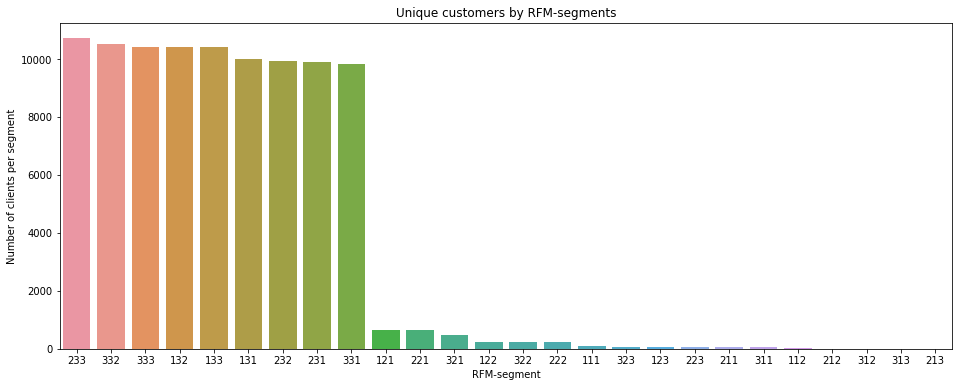

In [89]:
# Построим бар чарт, чтобы посмотреть число клиентов в каждом сегменте

plt.figure(figsize=(16, 6))
rfm_bar_chart = rfm.groupby('rfm_segment', as_index=False) \
                   .agg({'customer_unique_id': 'count'}) \
                   .sort_values('customer_unique_id', ascending=False)
sns.barplot(data=rfm_bar_chart, x='rfm_segment', y='customer_unique_id')
plt.title('Unique customers by RFM-segments')
plt.xlabel('RFM-segment')
plt.ylabel('Number of clients per segment')

Видно, что у нас преобладают пользователи с оценкой 3 по Frequency, то есть те, кто совершил только одну покупку за все время. Больше всего у нас пользователей RFM-сегмента 233 - с разовой покупкой средней давности и на маленькую сумму.

Далее, учитывая специфику данных, выделим несколько групп клиентов:

1. **champions** - недавно покупали, совершили больше одной покупки и на большую сумму (сегменты 111, 121)
2. **loyal** - совершили больше одной покупки недавно или со средней давностью на среднюю или низкую сумму (сегменты 112, 122, 123, 212, 213, 222, 223)
3. **whales** - тратят большие суммы, но последняя покупка была очень давно, либо средней давности (сегменты 211, 221, 231, 311, 321, 331)
4. **new** - недавно совершили свою первую покупку (сегменты 131, 132, 133)
5. **sleeping** - совершали покупки очень давно или со средней давностью со средней или маленькой суммой (сегменты 232, 233, 312, 322, 332, 313, 323, 333)

In [90]:
# Присвоим каждому RFM-сегменту выделенную группу

segment_map = {
    r'1[1-2]1': 'champions',
    r'[1-2][1-2][2-3]': 'loyal',
    r'[2-3][1-3]1': 'whales',
    r'13[1-3]': 'new',
    r'[2-3][1-3][2-3]': 'sleeping'
}

In [91]:
# Запишем присвоенные группы в новый столбец в нашем датафрейме

rfm['group'] = rfm['r'].map(str) + rfm['f'].map(str) + rfm['m'].map(str)
rfm['group'] = rfm['group'].replace(segment_map, regex=True)
rfm.head()

,customer_unique_id,recency,frequency,monetary,r,f,m,rfm_segment,group
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,1,3,1,131,new
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,1,3,3,133,new
2,0000f46a3911fa3c0805444483337064,542,1,69.00,3,3,2,332,sleeping
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,3,3,3,333,sleeping
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,2,3,1,231,whales


In [92]:
# Посмотрим, как распределились наши группы
rfm.group.value_counts(normalize=True).mul(100).round(2)

sleeping     44.12
new          32.42
whales       22.04
champions     0.77
loyal         0.64
Name: group, dtype: float64

In [93]:
# Сформируем список лейблов для графика из групп и их доли с помощью цикла

labels = []
n = 0

for i in rfm.group.value_counts(normalize=True).mul(100).round(2):
    labels.append(f'{rfm.group.value_counts(normalize=True).mul(100).round(2).index[n]}\n {rfm.group.value_counts(normalize=True).mul(100).round(2)[n]}%')
    n += 1

labels

['sleeping\n 44.12%',
 'new\n 32.42%',
 'whales\n 22.04%',
 'champions\n 0.77%',
 'loyal\n 0.64%']

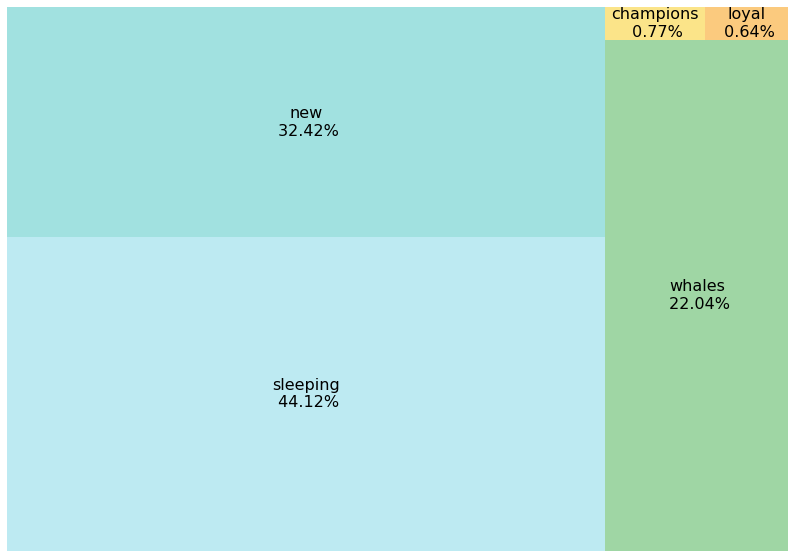

In [94]:
# Строим treemap

plt.figure(figsize=(14, 10))
plt.axis("off")

sq.plot(sizes=rfm.group.value_counts(),
        label=labels,
        text_kwargs={'fontsize': 16, 'color': 'black'},
        color=['#91DCEA', '#64CDCC', '#5FBB68', '#F9D23C', '#F9A729', '#FD6F30'],
        alpha=0.6)

Видно, что значительную долю у нас занимают **спящие** клиенты, то есть те, кто совершал покупки очень давно или со средней давностью со средней или маленькой суммой.<br>
Очень мало у нас самых сливок - **чемпионов** и **лояльных** (меньше 2%).<br>
Но также у нас достаточно много **новичков** (почти одна третья клиентов) и **китов** (около 22%).

# 5. Рекомендации для групп

1. **champions** - внедрить персонализированную программу лояльности, которая будет вознаграждать таких клиентов. Можно им первым предлагать появившиеся новые товары, продавать им более дорогие позиции, скидки лучше не предлагать. Предлагать эксклюзивные привилегии, самое ценное, например, золотую карту. Упор на вознаграждения и эксклюзив. Всё-таки таких клиентов у нас очень мало.<br><br>
2. **loyal** - просить оставить отзыв в сети, можно за какое либо вознаграждение: промокод на скидку/бонусы. Нужно стимулировать показатель Monetary, предлагать многоуровневые скидки, ранний доступ к распродажам, предложить сопутствующие товары, подарок за сделанную покупку, внедрить программу лояльности и т. д. Можно сделать их участниками реферальной системы, где у них будет своя ссылка, по которой они будут приводить рефералов.<br><br>
3. **whales** - эту группу можно конвертировать в группу активных покупателей. Надо про нас напомнить, отправлять персонализированные email, пуши, чтобы возобновить связь с клиентом. Предложить попробовать наши товары еше раз. Изучить, что эти клиенты покупали и предложить товар из схожей категории. Узнать, чего бы они хотели от компании в будущем. Предложить нечто особенное, ценное, дорогое. Не стоит предлагать скидки.<br><br>
4. **new** - помочь в выборе товара, дать полезный контент. Поздравить с покупкой, пригласить в соцсети, предложить выгодные акции. Это поможет установить крепкие отношения с клиентами всерьёз и надолго.<br><br>
5. **sleeping** - выяснить, почему перестали быть активными, и предложить им другие релевантные товары, а также специальные предложения, скидки и акции.